change path to image dir

test dataset

data augmentation

cache, prefetch

overfitting

stratergy: simple model first

pipeline

MAE/MSE/RMSE

change lambda regu

In [43]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11116, done.
remote: Counting objects: 100% (11116/11116), done.
remote: Compressing objects: 100% (11101/11101), done.
remote: Total 11116 (delta 62), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11116/11116), 175.34 MiB | 26.59 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images/facial_beauty_perception/FBP5500/Images


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.models import Model

seed = 42

In [45]:
image_size = (90, 90)
input_shape = (*image_size, 3)
batch_size = 32
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

In [46]:
scores_dataframe.head()

,file_name,score
0,AF1.jpg,2.333333
1,AF2.jpg,3.950000
2,AF3.jpg,3.183333
3,AF4.jpg,2.683333
4,AF5.jpg,2.000000


count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


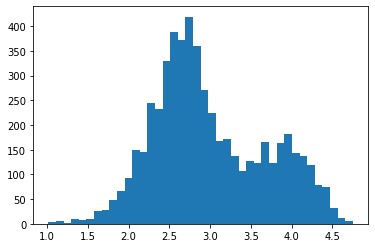

In [47]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40,)
plt.show()

In [48]:
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size)
    img = image.img_to_array(img)
    images.append(img/255.)

In [49]:
images = np.array(images)
scores = np.array(scores)
np.random.seed(seed)
np.random.shuffle(images)
np.random.seed(seed)
np.random.shuffle(scores)

In [50]:
print(images.shape)
print(scores.shape)

(5500, 90, 90, 3)
(5500,)


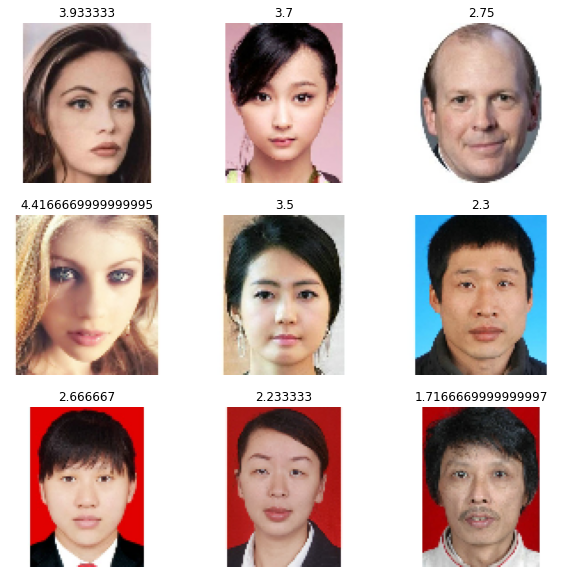

In [51]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(scores[i])
    plt.axis("off")

In [52]:
images_ds = tf.data.Dataset.from_tensor_slices(images)
scores_ds = tf.data.Dataset.from_tensor_slices(scores)

In [53]:
n_train = 4400
v_validation = 1100
buffer_size = 5500

In [54]:
x_train = images_ds.take(n_train)
x_val = images_ds.skip(n_train)

y_train = scores_ds.take(n_train)
y_val = scores_ds.skip(n_train)

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [56]:
ds = tf.data.Dataset.from_tensor_slices((images, scores))

train_ds = ds.take(n_train)
val_ds = ds.skip(n_train)

In [57]:
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### Build architectures

In [58]:
def identity_block(X, f, filters, training=True, kernel_regularizer=None, dropout=False):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    kernel_regularizer -- to set up the weights regularization of a layer.
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [59]:
def convolutional_block(X, f, filters, s=2, training=True, kernel_regularizer=None, dropout=False):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    kernel_regularizer -- to set up the weights regularization of a layer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X_shortcut)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [60]:
def ResNet11(input_shape=(64, 64, 3), kernel_regularizer=None, dropout=False):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


In [61]:
def ResNet50(input_shape=(64, 64, 3), kernel_regularizer=None, dropout=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

### Utilities

In [62]:
import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


In [63]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [64]:
patience = 20
max_epochs = 90
steps_per_epoch = n_train//batch_size

In [65]:
def get_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_nonregu_mae', patience=patience),
            tf.keras.callbacks.TensorBoard(logdir/name)
            ]

In [66]:
def compile_and_fit(model, optimizer='adam', callbacks=None, train_data=train_ds_prefetch, epochs=max_epochs):
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=[tf.keras.losses.MeanAbsoluteError(
            name='nonregu_mae'
        )]
    )

    history = model.fit(
        x=train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_ds_prefetch,
        callbacks=callbacks,
    )

    return history

In [67]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1qc12tc
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1qc12tc


In [68]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

### Testing

In [70]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [71]:
model = ResNet11(input_shape)

optimizer = Adam(learning_rate=0.0000001)

# conv2d_40 = model.get_layer('conv2d_40')

loss_value, gradients = grad(model, images[:30], scores[:30])

print('Step 0, initial loss: {}'.format(loss_value.numpy()))

# optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# loss_value, gradients = grad(model, images[:30], scores[:30])

# print('Step 1: {}'.format(loss_value.numpy()))      # WHY??????????????????????????????????

Step 0, initial loss: 2.2664642333984375


(array([  15.,   37.,   58.,   83.,  152.,  245.,  305.,  423.,  530.,
         712., 1035., 1270., 1856., 2596., 4798., 4325., 2577., 1826.,
        1294.,  992.,  770.,  530.,  392.,  283.,  203.,  148.,   91.,
          50.,   36.,   16.]),
 array([-3.28866041e-02, -3.06895751e-02, -2.84925461e-02, -2.62955172e-02,
        -2.40984882e-02, -2.19014592e-02, -1.97044303e-02, -1.75074013e-02,
        -1.53103723e-02, -1.31133434e-02, -1.09163144e-02, -8.71928543e-03,
        -6.52225646e-03, -4.32522749e-03, -2.12819852e-03,  6.88304446e-05,
         2.26585941e-03,  4.46288838e-03,  6.65991735e-03,  8.85694632e-03,
         1.10539753e-02,  1.32510043e-02,  1.54480332e-02,  1.76450622e-02,
         1.98420912e-02,  2.20391201e-02,  2.42361491e-02,  2.64331781e-02,
         2.86302070e-02,  3.08272360e-02,  3.30242650e-02]),
 <a list of 30 Patch objects>)

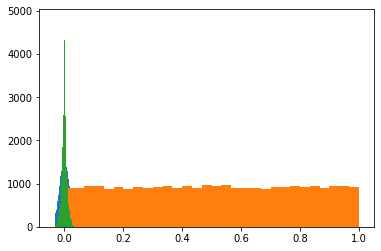

In [98]:
# ex_weights = tf.keras.initializers.HeNormal()(shape=(96, 96, 3)).numpy()
# ex_img = np.random.rand(96, 96, 3)
# plt.hist(ex_weights.reshape(-1,), bins=30)
# plt.hist(ex_img.reshape(-1,), bins=30)
# plt.hist(ex_weights.reshape(-1,) * ex_img.reshape(-1,), bins=30)

Inputing shape: (1, 90, 90, 3) to zero_padding2d_3 with expected input shape: (None, 90, 90, 3)
Inputing shape: (1, 96, 96, 3) to conv2d_8 with expected input shape: (None, 96, 96, 3)
Inputing shape: (1, 45, 45, 64) to batch_normalization_8 with expected input shape: (None, 45, 45, 64)
Inputing shape: (1, 45, 45, 64) to activation_7 with expected input shape: (None, 45, 45, 64)
Inputing shape: (1, 45, 45, 64) to max_pooling2d_1 with expected input shape: (None, 45, 45, 64)
Inputing shape: (1, 22, 22, 64) to conv2d_9 with expected input shape: (None, 22, 22, 64)
Inputing shape: (1, 22, 22, 64) to batch_normalization_9 with expected input shape: (None, 22, 22, 64)
Inputing shape: (1, 22, 22, 64) to activation_8 with expected input shape: (None, 22, 22, 64)
Inputing shape: (1, 22, 22, 64) to conv2d_10 with expected input shape: (None, 22, 22, 64)
Inputing shape: (1, 22, 22, 64) to batch_normalization_10 with expected input shape: (None, 22, 22, 64)
Inputing shape: (1, 22, 22, 64) to activ

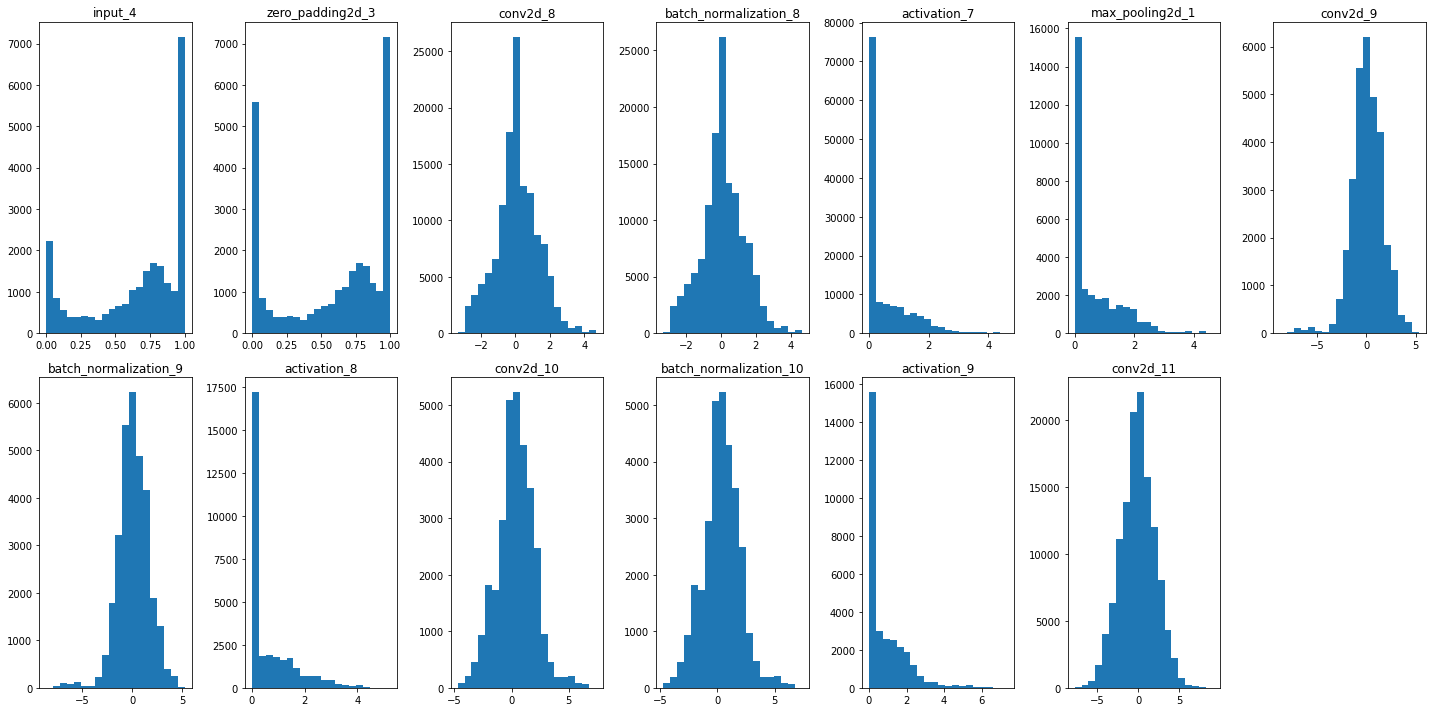

In [96]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

plot_activations(model, images[1])

In [31]:
model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 90, 90, 3)]              0                                                                   
______________________________________________________________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D)                 (None, 96, 96, 3)                0                 input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, 45, 45, 64)            

In [33]:
loss_value, gradients = grad(model, images[:30], scores[:30])


In [34]:
loss_value

<tf.Tensor: shape=(), dtype=float32, numpy=69.73781>

### Learning rate decay

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecay, CosineDecayRestarts, ExponentialDecay, InverseTimeDecay, PiecewiseConstantDecay

In [ ]:
cosine_decay = CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=steps_per_epoch * max_epochs,
    alpha=1/100,
    name='CosineDecay'
)

In [ ]:
cosine_decay_restarts = CosineDecayRestarts(
    initial_learning_rate=0.01,
    first_decay_steps=steps_per_epoch,
    alpha=1/100,
    t_mul=1.5,
    m_mul=0.9,
    name='CosineDecayRestarts'
)

In [ ]:
inverse_time_decay = InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=steps_per_epoch/3,
    decay_rate=0.2,
    staircase=False,
    name='InverseTimeDecay'
)

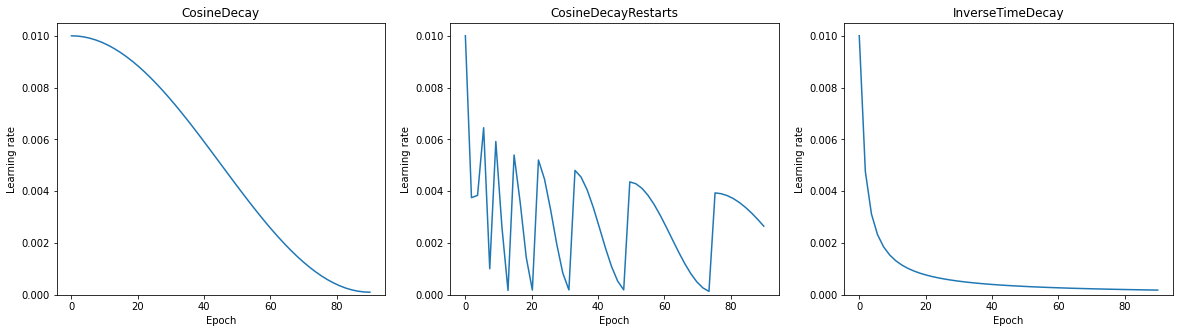

In [ ]:
step = np.linspace(0, steps_per_epoch * max_epochs)

plt.figure(figsize=(20, 5))
i = 1
for scheduler in [cosine_decay, cosine_decay_restarts, inverse_time_decay]:
    lr = scheduler(step)
    plt.subplot(1, 3, i)
    i += 1
    plt.plot(step/steps_per_epoch, lr)
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.title(scheduler.name)
    _ = plt.ylabel('Learning rate')


In [ ]:
lr_histories = {}

In [ ]:
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/'lr/cosine_decay', ignore_errors=True)
optimizer = Adam(cosine_decay)

np.random.seed(seed)

lr_histories['cosine_decay'] = compile_and_fit(
    model,
    name=get_callback('lr/cosine_decay'),
    optimizer=optimizer
)

In [ ]:
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/'lr/cosine_decay_restarts', ignore_errors=True)
optimizer = Adam(cosine_decay_restarts)

np.random.seed(seed)

lr_histories['cosine_decay_restarts'] = compile_and_fit(
    model,
    name=get_callback('lr/cosine_decay_restarts'),
    optimizer=optimizer
)

In [ ]:
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/'lr/inverse_time_decay', ignore_errors=True)
optimizer = Adam(inverse_time_decay)

np.random.seed(seed)

lr_histories['inverse_time_decay'] = compile_and_fit(
    model,
    name=get_callback('lr/inverse_time_decay'),
    optimizer=optimizer
)

Text(0.5, 0, 'Epochs')

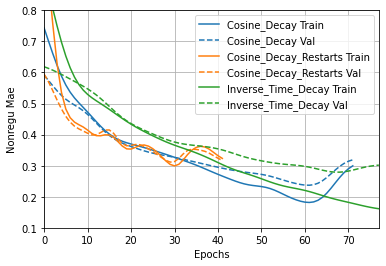

In [ ]:
plotter.plot(lr_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0.1, 0.8])
plt.xlabel('Epochs')        # <---- add [Log scale]

### Regularizations

In [ ]:
regularization_histories = {}

In [ ]:
model_regu_dropout = ResNet50(input_shape=input_shape, kernel_regularizer='l2', dropout=True)

shutil.rmtree(logdir/'regularizations/regu_dropout', ignore_errors=True)

np.random.seed(seed)

regularization_histories['regu_dropout'] = compile_and_fit(
    model_regu_dropout,
    name=get_callback('regularizations/regu_dropout'),
    optimizer=Adam(cosine_decay),
)

In [ ]:
model_raw = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/'regularizations/raw', ignore_errors=True)

np.random.seed(seed)

regularization_histories['raw'] = compile_and_fit(
    model_raw,
    name=get_callback('regularizations/raw'),
    optimizer=Adam(cosine_decay),
)

In [ ]:
model_regu = ResNet50(input_shape=input_shape, kernel_regularizer='l2')

shutil.rmtree(logdir/'regularizations/regu', ignore_errors=True)

np.random.seed(seed)

regularization_histories['regu'] = compile_and_fit(
    model_regu,
    name=get_callback('regularizations/regu'),
    optimizer=Adam(cosine_decay),
)

In [ ]:
model_dropout = ResNet50(input_shape=input_shape, dropout=True)

shutil.rmtree(logdir/'regularizations/dropout', ignore_errors=True)

np.random.seed(seed)

regularization_histories['dropout'] = compile_and_fit(
    model_dropout,
    name=get_callback('regularizations/dropout'),
    optimizer=Adam(cosine_decay),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Epochs')

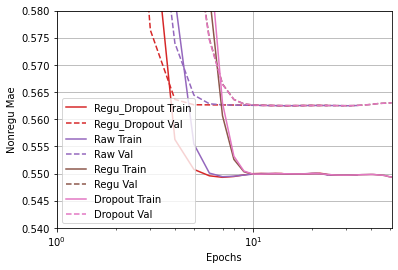

In [ ]:
plotter.plot(regularization_histories)
a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0.54, 0.58])
plt.xlabel('Epochs')        # <---- add [Log scale]

### Optimizers

In [ ]:
optimizer_histories = {}

In [ ]:
shutil.rmtree(logdir/"optimizers/adam", ignore_errors=True)
shutil.copytree(logdir/"regularizations/raw", logdir/"optimizers/adam")

PosixPath('/tmp/tmprx6rvzt2/tensorboard_logs/optimizers/adam')

In [ ]:
# # ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# # NHỚ CHỈNH LẠI TÊN CÁC THỨ

# shutil.rmtree(logdir/"optimizers/adam", ignore_errors=True)

# model = ResNet50(input_shape=input_shape)

np.random.seed(seed)

# optimizer_histories['adam'] = compile_and_fit(
#     model,
#     name=get_callback('optimizers/adam'),
#     optimizer='adam'
# )

In [ ]:
# ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# NHỚ CHỈNH LẠI TÊN CÁC THỨ
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/"optimizers/sgd_momentum", ignore_errors=True)

np.random.seed(seed)

optimizer_histories['sgd_momentum'] = compile_and_fit(
    model,
    name=get_callback('optimizers/sgd_momentum'),
    optimizer=SGD(momentum=0.9)
)

In [ ]:
# ĐỢI TAB REGU CHẠY XONG RỒI MANG NHÁNH LOGDIR CỦA NÓ SANG ĐÂY ĐỠ TỐN CÔNG
# NHỚ CHỈNH LẠI TÊN CÁC THỨ
model = ResNet50(input_shape=input_shape)

shutil.rmtree(logdir/"optimizers/sgd_nesterov", ignore_errors=True)

np.random.seed(seed)

optimizer_histories['sgd_nesterov'] = compile_and_fit(
    model,
    name=get_callback('optimizers/sgd_nesterov'),
    optimizer=SGD(momentum=0.9, nesterov=True)
)

In [ ]:
plotter.plot(optimizer_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([-1, 5])
plt.xlabel('Epochs') # [Log scale]

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
predictions = tf.data.Dataset.from_tensor_slices(model.predict(val_ds1)).batch(batch_size)

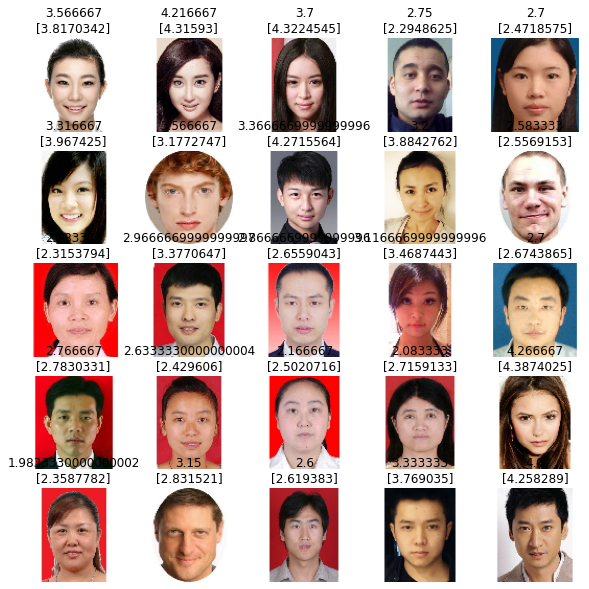

In [ ]:
plt.figure(figsize=(10, 10))
for images, true_scores in val_ds1.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])
            plt.title('{}\n{}'.format(true_scores[i], pred_scores[i]))
            plt.axis("off")